In [1]:
!pip install torch torchvision torchaudio

In [2]:
import torch
print(torch.__version__)

2.4.1+cpu


In [3]:
pip install tensorflow==2.9.0

Note: you may need to restart the kernel to use updated packages.


# Preprocessing

In [1]:
import numpy as np
import pandas as pd

In [6]:
import os
import shutil
import random
import matplotlib.pyplot as plt

# กำหนด path
path_folder = 'D:/acefeb/it/ISD/recycle_data/images'
base_dir = 'D:/acefeb/it/ISD/recycle_data'  # Directory สำหรับ train, val, test

# สร้าง folder สำหรับ train, val, test นอกโฟลเดอร์ images
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

# สัดส่วนการแบ่งข้อมูล
train_split = 0.7
val_split = 0.2
test_split = 0.1

# ฟังก์ชันสำหรับการแบ่งข้อมูล
def split_data(src_dir, train_dir, val_dir, test_dir, train_size, val_size):
    for class_folder in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_folder)
        if os.path.isdir(class_path):
            images = []
            for subfolder in ['default', 'real_world']:
                subfolder_path = os.path.join(class_path, subfolder)
                if os.path.exists(subfolder_path):
                    images += [os.path.join(subfolder_path, img) for img in os.listdir(subfolder_path)]

            random.shuffle(images)
            train_images = images[:int(len(images) * train_size)]
            val_images = images[int(len(images) * train_size):int(len(images) * (train_size + val_size))]
            test_images = images[int(len(images) * (train_size + val_size)):]

            # สร้าง folder ของ class ใน train, val, test
            for split_dir, split_images in [(train_dir, train_images), (val_dir, val_images), (test_dir, test_images)]:
                class_split_dir = os.path.join(split_dir, class_folder)
                if not os.path.exists(class_split_dir):
                    os.makedirs(class_split_dir)
                for img_path in split_images:
                    shutil.copy(img_path, class_split_dir)

# แบ่งข้อมูล
split_data(path_folder, train_dir, val_dir, test_dir, train_split, val_split)


C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# กำหนด path สำหรับ train, val, test
train_dir = 'D:/acefeb/it/ISD/recycle_data/train'
val_dir = 'D:/acefeb/it/ISD/recycle_data/val'
test_dir = 'D:/acefeb/it/ISD/recycle_data/test'

# โหลดข้อมูล
train_ds = image_dataset_from_directory(train_dir, image_size=(256, 256), batch_size=32, label_mode='categorical')
val_ds = image_dataset_from_directory(val_dir, image_size=(256, 256), batch_size=32, label_mode='categorical')
test_ds = image_dataset_from_directory(test_dir, image_size=(256, 256), batch_size=32, label_mode='categorical')

# ดึงชื่อ class จาก dataset
class_names = train_ds.class_names

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 7452 files belonging to 30 classes.
Found 4447 files belonging to 30 classes.
Found 2654 files belonging to 30 classes.


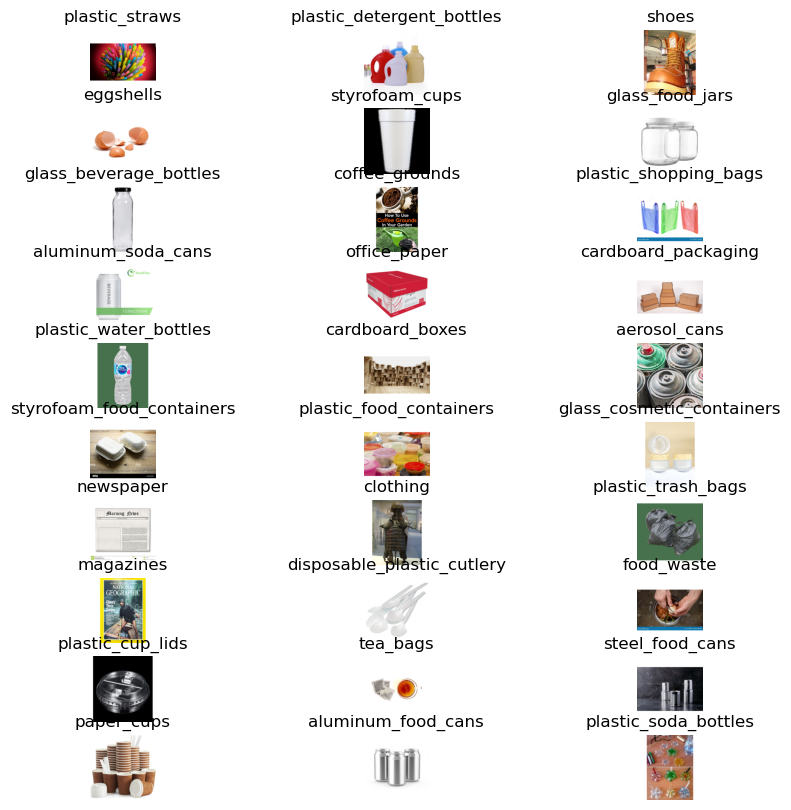

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# สร้าง dictionary เก็บภาพตัวอย่างสำหรับแต่ละ class
class_sample_images = {}

# Loop ผ่าน dataset
for images, labels in train_ds:
    for i in range(len(labels)):
        label_index = np.argmax(labels[i].numpy())  # แปลง one-hot label กลับเป็น index
        class_name = class_names[label_index]
        
        # เก็บภาพตัวอย่างแรกของแต่ละ class
        if class_name not in class_sample_images:
            class_sample_images[class_name] = images[i].numpy().astype("uint8")
        
        # หยุดเมื่อเก็บครบทุก class
        if len(class_sample_images) == len(class_names):
            break
    if len(class_sample_images) == len(class_names):
        break

# แสดงภาพตัวอย่างสำหรับทุก class
plt.figure(figsize=(10, 10))
for i, (class_name, image) in enumerate(class_sample_images.items()):
    ax = plt.subplot(10, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.show()


# Model

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [4]:
# ฟังก์ชันปรับ Learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
# ใช้ LearningRateScheduler เพื่อปรับ learning rate ตาม epoch
lr_scheduler = LearningRateScheduler(scheduler)

In [9]:

# โหลดโมเดล ResNet50 ที่ pretrained จาก ImageNet
base_model = tf.keras.applications.ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# สร้าง Sequential Model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(30, activation='softmax')  # Output 30 classes
])

# Compile โมเดล
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# สร้าง ModelCheckpoint เพื่อเซฟโมเดลที่ดีที่สุดระหว่างการเทรน
checkpoint = ModelCheckpoint(
    filepath='D:/acefeb/it/ISD/saved_model_checkpoint/new_model.h5',  # ที่อยู่และชื่อไฟล์โมเดลที่ต้องการเซฟ
    monitor='val_accuracy',  # Metric ที่ใช้ในการวัด (เช่น val_accuracy)
    save_best_only=True,  # เซฟเฉพาะโมเดลที่ดีที่สุด
    mode='max',  # 'max' สำหรับ accuracy, 'min' สำหรับ loss
    verbose=1  # แสดงผลเมื่อมีการเซฟโมเดล
)

# เทรนโมเดล
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[lr_scheduler, checkpoint]  # เพิ่ม callback ของ ModelCheckpoint
)


Epoch 1/10
233/233 [==============================] - ETA: 0s - loss: 1.7623 - accuracy: 0.5008 - precision: 0.6993 - recall: 0.3814
Epoch 1: val_accuracy improved from -inf to 0.74162, saving model to D:/acefeb/it/ISD/saved_model_checkpoint\new_model.h5
233/233 [==============================] - 1006s 4s/step - loss: 1.7623 - accuracy: 0.5008 - precision: 0.6993 - recall: 0.3814 - val_loss: 0.8386 - val_accuracy: 0.7416 - val_precision: 0.8449 - val_recall: 0.6310 - lr: 0.0010
Epoch 2/10
233/233 [==============================] - ETA: 0s - loss: 0.9298 - accuracy: 0.7120 - precision: 0.8058 - recall: 0.6349
Epoch 2: val_accuracy improved from 0.74162 to 0.79267, saving model to D:/acefeb/it/ISD/saved_model_checkpoint\new_model.h5
233/233 [==============================] - 1014s 4s/step - loss: 0.9298 - accuracy: 0.7120 - precision: 0.8058 - recall: 0.6349 - val_loss: 0.6814 - val_accuracy: 0.7927 - val_precision: 0.8655 - val_recall: 0.7191 - lr: 0.0010
Epoch 3/10
233/233 [===========

In [5]:
model = tf.keras.models.load_model('D:/acefeb/it/ISD/saved_model_checkpoint/new_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 30)                61470     
                                                                 
Total params: 23,649,182
Trainable params: 61,470
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
# ปลดล็อกบางเลเยอร์ใน ResNet50
base_model = model.layers[0]  # Assuming the first layer is the base model
base_model.trainable = True  # ปลดล็อก base model

# กำหนดให้ unfreeze เฉพาะบางเลเยอร์ เช่น Unfreeze เฉพาะชั้นที่ลึกๆ
for layer in base_model.layers[:100]:  # Freeze เฉพาะ 100 เลเยอร์แรก (จากทั้งหมด 175)
    layer.trainable = False


In [7]:
# Compile โมเดลใหม่ พร้อมกำหนด learning rate ที่เล็กลงสำหรับ fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Learning rate เล็กลง
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [8]:
# ใช้ ModelCheckpoint เพื่อเซฟโมเดลทับ
checkpoint = ModelCheckpoint(
    filepath='D:/acefeb/it/ISD/saved_model_checkpoint/new_finetune_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [9]:
# เทรนโมเดลต่อ
history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # Fine-tune เพิ่มเติมอีก 5 epochs
    callbacks=[lr_scheduler, checkpoint]
)


Epoch 1/5
233/233 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.7736 - precision: 0.8246 - recall: 0.7398
Epoch 1: val_accuracy improved from -inf to 0.85631, saving model to D:/acefeb/it/ISD/saved_model_checkpoint\new_finetune_model.h5
233/233 [==============================] - 1723s 7s/step - loss: 0.7245 - accuracy: 0.7736 - precision: 0.8246 - recall: 0.7398 - val_loss: 0.5054 - val_accuracy: 0.8563 - val_precision: 0.8796 - val_recall: 0.8381 - lr: 1.0000e-05
Epoch 2/5
233/233 [==============================] - ETA: 0s - loss: 0.4203 - accuracy: 0.8552 - precision: 0.8886 - recall: 0.8281
Epoch 2: val_accuracy improved from 0.85631 to 0.86193, saving model to D:/acefeb/it/ISD/saved_model_checkpoint\new_finetune_model.h5
233/233 [==============================] - 1645s 7s/step - loss: 0.4203 - accuracy: 0.8552 - precision: 0.8886 - recall: 0.8281 - val_loss: 0.4622 - val_accuracy: 0.8619 - val_precision: 0.8918 - val_recall: 0.8453 - lr: 1.0000e-05
Epoch 3

In [10]:
model.save('D:/acefeb/it/ISD/saved_model/')
model.save('D:/acefeb/it/ISD/saved_model_checkpoint/allmodel.h5')

INFO:tensorflow:Assets written to: D:/acefeb/it/ISD/saved_model/assets


INFO:tensorflow:Assets written to: D:/acefeb/it/ISD/saved_model/assets


# Evaluate

In [15]:
import matplotlib.pyplot as plt

In [11]:
# วัดผลโมเดลบน test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_ds)

print(f'Test Accuracy: {test_acc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test Loss: {test_loss}')

83/83 [==============================] - 295s 3s/step - loss: 0.4499 - accuracy: 0.8775 - precision: 0.8991 - recall: 0.8662
Test Accuracy: 0.8775433301925659
Test Precision: 0.8991004824638367
Test Recall: 0.8662396669387817
Test Loss: 0.4499483108520508


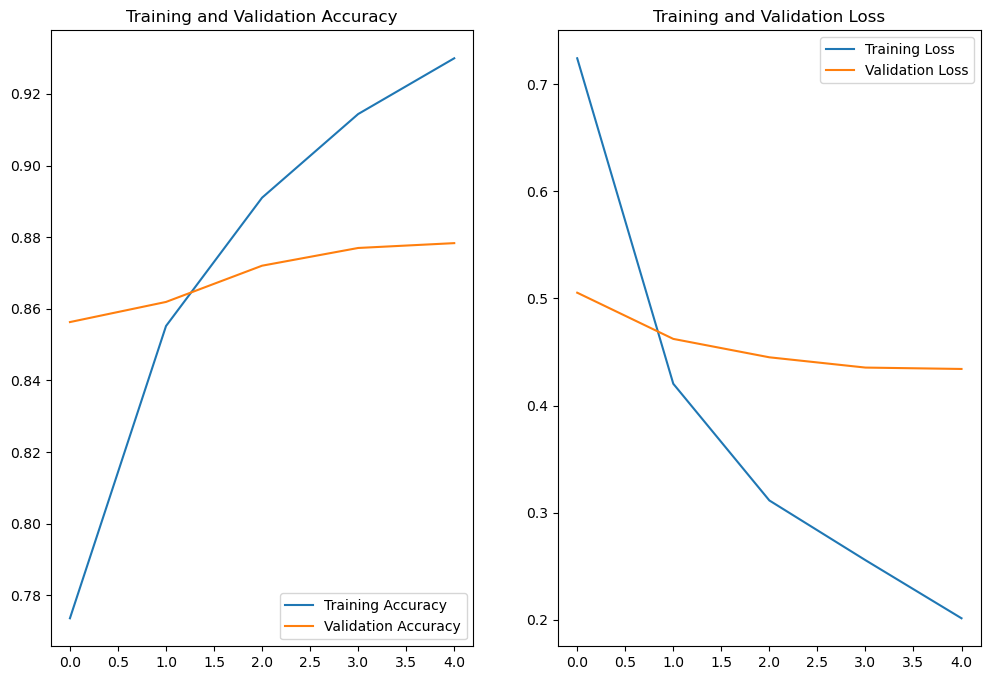

In [16]:
# แสดงกราฟผลการเทรน
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# แสดงผลการเทรน
plot_training_history(history_fine_tune )

# Prediction

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/acefeb/it/ISD/recycle_data/images/test',  # path ของ test_folder
    image_size=(256, 256),  # ขนาดรูปภาพที่ปรับเพื่อเข้ากับโมเดล
    batch_size=32,  # ขนาด batch
    label_mode='categorical'  # ใช้ one-hot encoding เพื่อให้เข้ากับโมเดล
)

In [ ]:
# Loop ผ่าน dataset ด้วยการดึง images และ labels ออกมาแยกกัน
for batch in test_ds.take(1):
    images, labels = batch  # Unpack เฉพาะ images และ labels
    print(images.shape, labels.shape)  # ตรวจสอบ shape ของ images และ labels

In [ ]:
# ทำนาย class จากข้อมูลใน test set
predictions = model.predict(test_ds)

# แสดงผลการทำนายของ batch แรก
print(predictions[0])  # ผลลัพธ์เป็น probabilistic distribution ของแต่ละ class
predicted_class = np.argmax(predictions[0])  # หาค่า class ที่มีความน่าจะเป็นสูงสุด
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 2s 2s/step


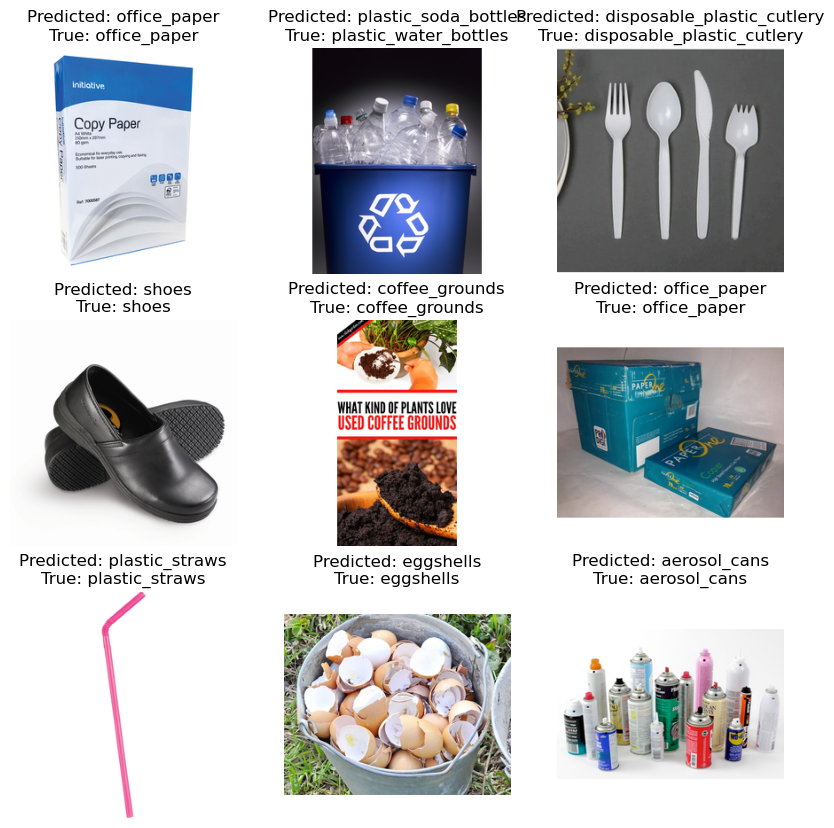

In [28]:
# แสดงภาพพร้อมกับผลการทำนาย class และ true label
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    predictions = model.predict(images)  # ทำนายผลลัพธ์
    predicted_labels = np.argmax(predictions, axis=1)  # หาค่า class ที่ทำนายได้
    true_labels = np.argmax(labels.numpy(), axis=1)  # หาค่า true class จาก one-hot encoded labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class_name = class_names[predicted_labels[i]]  # ชื่อคลาสที่ทำนายได้
        true_class_name = class_names[true_labels[i]]  # ชื่อคลาสที่แท้จริง
        plt.title(f'Predicted: {predicted_class_name}\nTrue: {true_class_name}')
        plt.axis("off")
plt.show()


1/1 [==============================] - 1s 846ms/step


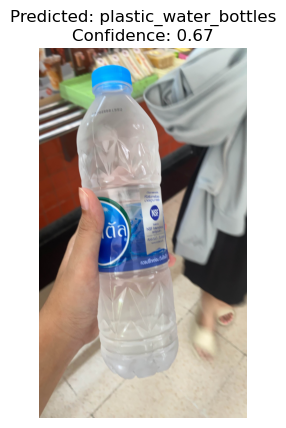

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1. ฟังก์ชันสำหรับโหลดและแปลงรูปภาพใหม่
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    # เปิดไฟล์รูปภาพ
    img = Image.open(image_path)
    # Resize รูปภาพให้มีขนาดเท่ากับ input ที่โมเดลคาดหวัง
    img = img.resize(target_size)
    # แปลงรูปภาพเป็น array และ normalize
    img_array = np.array(img)
    # เพิ่ม dimension เพื่อให้เป็นรูปแบบที่โมเดลอ่านได้
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# 2. ฟังก์ชันสำหรับการแสดงภาพพร้อมผลการทำนาย
def predict_and_display(image_path, model, class_names):
    # โหลดและเตรียมรูปภาพใหม่
    processed_image = load_and_preprocess_image(image_path)
    
    # ทำนายผลลัพธ์
    predictions = model.predict(processed_image)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]  # ค่าความมั่นใจ
    
    # แสดงภาพ
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_name}\nConfidence: {confidence:.2f}')
    plt.axis("off")
    plt.show()

# 3. ลองทำนายผลลัพธ์จากรูปภาพใหม่
image_path = "D:/acefeb/it/ISD/bottle2.jpg"  # ระบุ path ของรูปภาพที่ต้องการทำนาย
class_names = train_ds.class_names

# โหลดโมเดลที่ฝึกแล้ว
model = tf.keras.models.load_model('D:/acefeb/it/ISD/saved_model_checkpoint/allmodel.h5')


# เรียกฟังก์ชันเพื่อตรวจสอบและแสดงผลการทำนาย
predict_and_display(image_path, model, class_names)
